# Градиентный бустинг

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Создадим датасет в виде зашумленного косинуса

In [2]:
X = np.random.rand(100) * 10 - 5 

In [4]:
y = np.cos(X) +np.random.rand(100)/2 - 0.25
y[:5]

array([-0.75747332, -0.63316131,  0.14080425, -0.77920042, -0.99651491])

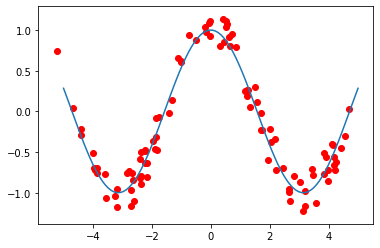

In [17]:
plt.plot(np.linspace(-5, 5, 100), np.cos(np.linspace(-5, 5, 100)))
plt.scatter(X, y, c='r')

In [1]:
123

123